### Plotting GEFS 0.5 degree
The Global Ensemble Forecast System (GEFS) is the backbone of our Clyfar data collection that serves as initial conditions (input values) to the inference stage. It is a global model, and uses degree of latitude to measure the width of the grid-cells (think of the GEFS data as a 3D block of cubes each with information about that block of air like its temperature, speed, etc). We would prefer the higher resolution 0.25 degree data (`gefs_0p25` or `0p25` in some of the API keys etc) -- corresponding to about 25 km -- but it is newer and some of it causes errors in `Herbie`. Until we work all that out, the coarser `0p5` should be used as a fall-back in some uses. 

Here is what the data look like on a map so it's easier to conceptualise. This data next need to reducing to "representative values" that mimic representative observations of ozone and weather obs around the Basin. Further, we want to test more including:

* Saving and loading to file
* How much data to save
* How to slice (and save) and visualise cross-sections (i.e., we'd see the cold pool in NWP data as a dome of cold air)
* How things like mountains look in 0.5 degree data, versus 0.25 degree GEFS and 3km HRRR/RRFS in future. 

In [1]:
import importlib
import datetime

import numpy as np

from nwp.gefsdata import GEFSData
from nwp.hrrrdata import HRRRData
from viz import plotting
import utils.utils as utils
from utils.lookups import elevations

In [2]:
lon, lat = (360 - 109.6774, 40.0891) # Where is this?
init_dt = datetime.datetime(2023,12,5,6,0,0)

### Plotting a surface map 
The following shows snow depth at 12 hours from the initial time from the GEFS model

TODO: use `FastHerbie` for faster data retrieval if possible

In [3]:
H = GEFSData.setup_herbie(init_dt, fxx=0, product="atmos.5", model="gefs",member='c00')
H.inventory()

✅ Found ┊ model=gefs ┊ product=atmos.5 ┊ 2023-Dec-05 06:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


,grib_message,start_byte,end_byte,range,reference_time,valid_time,variable,level,forecast_time,?,search_this
0,1,0,212777.0,0-212777,2023-12-05 06:00:00,2023-12-05 06:00:00,HGT,10 mb,anl,ENS=low-res ctl,:HGT:10 mb:anl:ENS=low-res ctl
1,2,212778,338956.0,212778-338956,2023-12-05 06:00:00,2023-12-05 06:00:00,TMP,10 mb,anl,ENS=low-res ctl,:TMP:10 mb:anl:ENS=low-res ctl
2,3,338957,364458.0,338957-364458,2023-12-05 06:00:00,2023-12-05 06:00:00,RH,10 mb,anl,ENS=low-res ctl,:RH:10 mb:anl:ENS=low-res ctl
3,4,364459,513103.0,364459-513103,2023-12-05 06:00:00,2023-12-05 06:00:00,UGRD,10 mb,anl,ENS=low-res ctl,:UGRD:10 mb:anl:ENS=low-res ctl
4,5,513104,651341.0,513104-651341,2023-12-05 06:00:00,2023-12-05 06:00:00,VGRD,10 mb,anl,ENS=low-res ctl,:VGRD:10 mb:anl:ENS=low-res ctl
...,...,...,...,...,...,...,...,...,...,...,...
66,67,12799566,13051358.0,12799566-13051358,2023-12-05 06:00:00,2023-12-05 06:00:00,VGRD,10 m above ground,anl,ENS=low-res ctl,:VGRD:10 m above ground:anl:ENS=low-res ctl
67,68,13051359,13204085.0,13051359-13204085,2023-12-05 06:00:00,2023-12-05 06:00:00,PWAT,entire atmosphere (considered as a single layer),anl,ENS=low-res ctl,:PWAT:entire atmosphere (considered as a singl...
68,69,13204086,13342108.0,13204086-13342108,2023-12-05 06:00:00,2023-12-05 06:00:00,CAPE,180-0 mb above ground,anl,ENS=low-res ctl,:CAPE:180-0 mb above ground:anl:ENS=low-res ctl
69,70,13342109,13435034.0,13342109-13435034,2023-12-05 06:00:00,2023-12-05 06:00:00,CIN,180-0 mb above ground,anl,ENS=low-res ctl,:CIN:180-0 mb above ground:anl:ENS=low-res ctl


✅ Found ┊ model=gefs ┊ product=atmos.5 ┊ 2023-Dec-05 06:00 UTC F06 ┊ GRIB2 @ aws ┊ IDX @ aws


/Users/johnlawson/anaconda3/envs/clyfar/lib/python3.11/site-packages/cartopy/mpl/feature_artist.py:144: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
/var/folders/rr/m6rsyqmd64q6ddlcqfq1sng00000gp/T/ipykernel_30928/3446574795.py:6: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


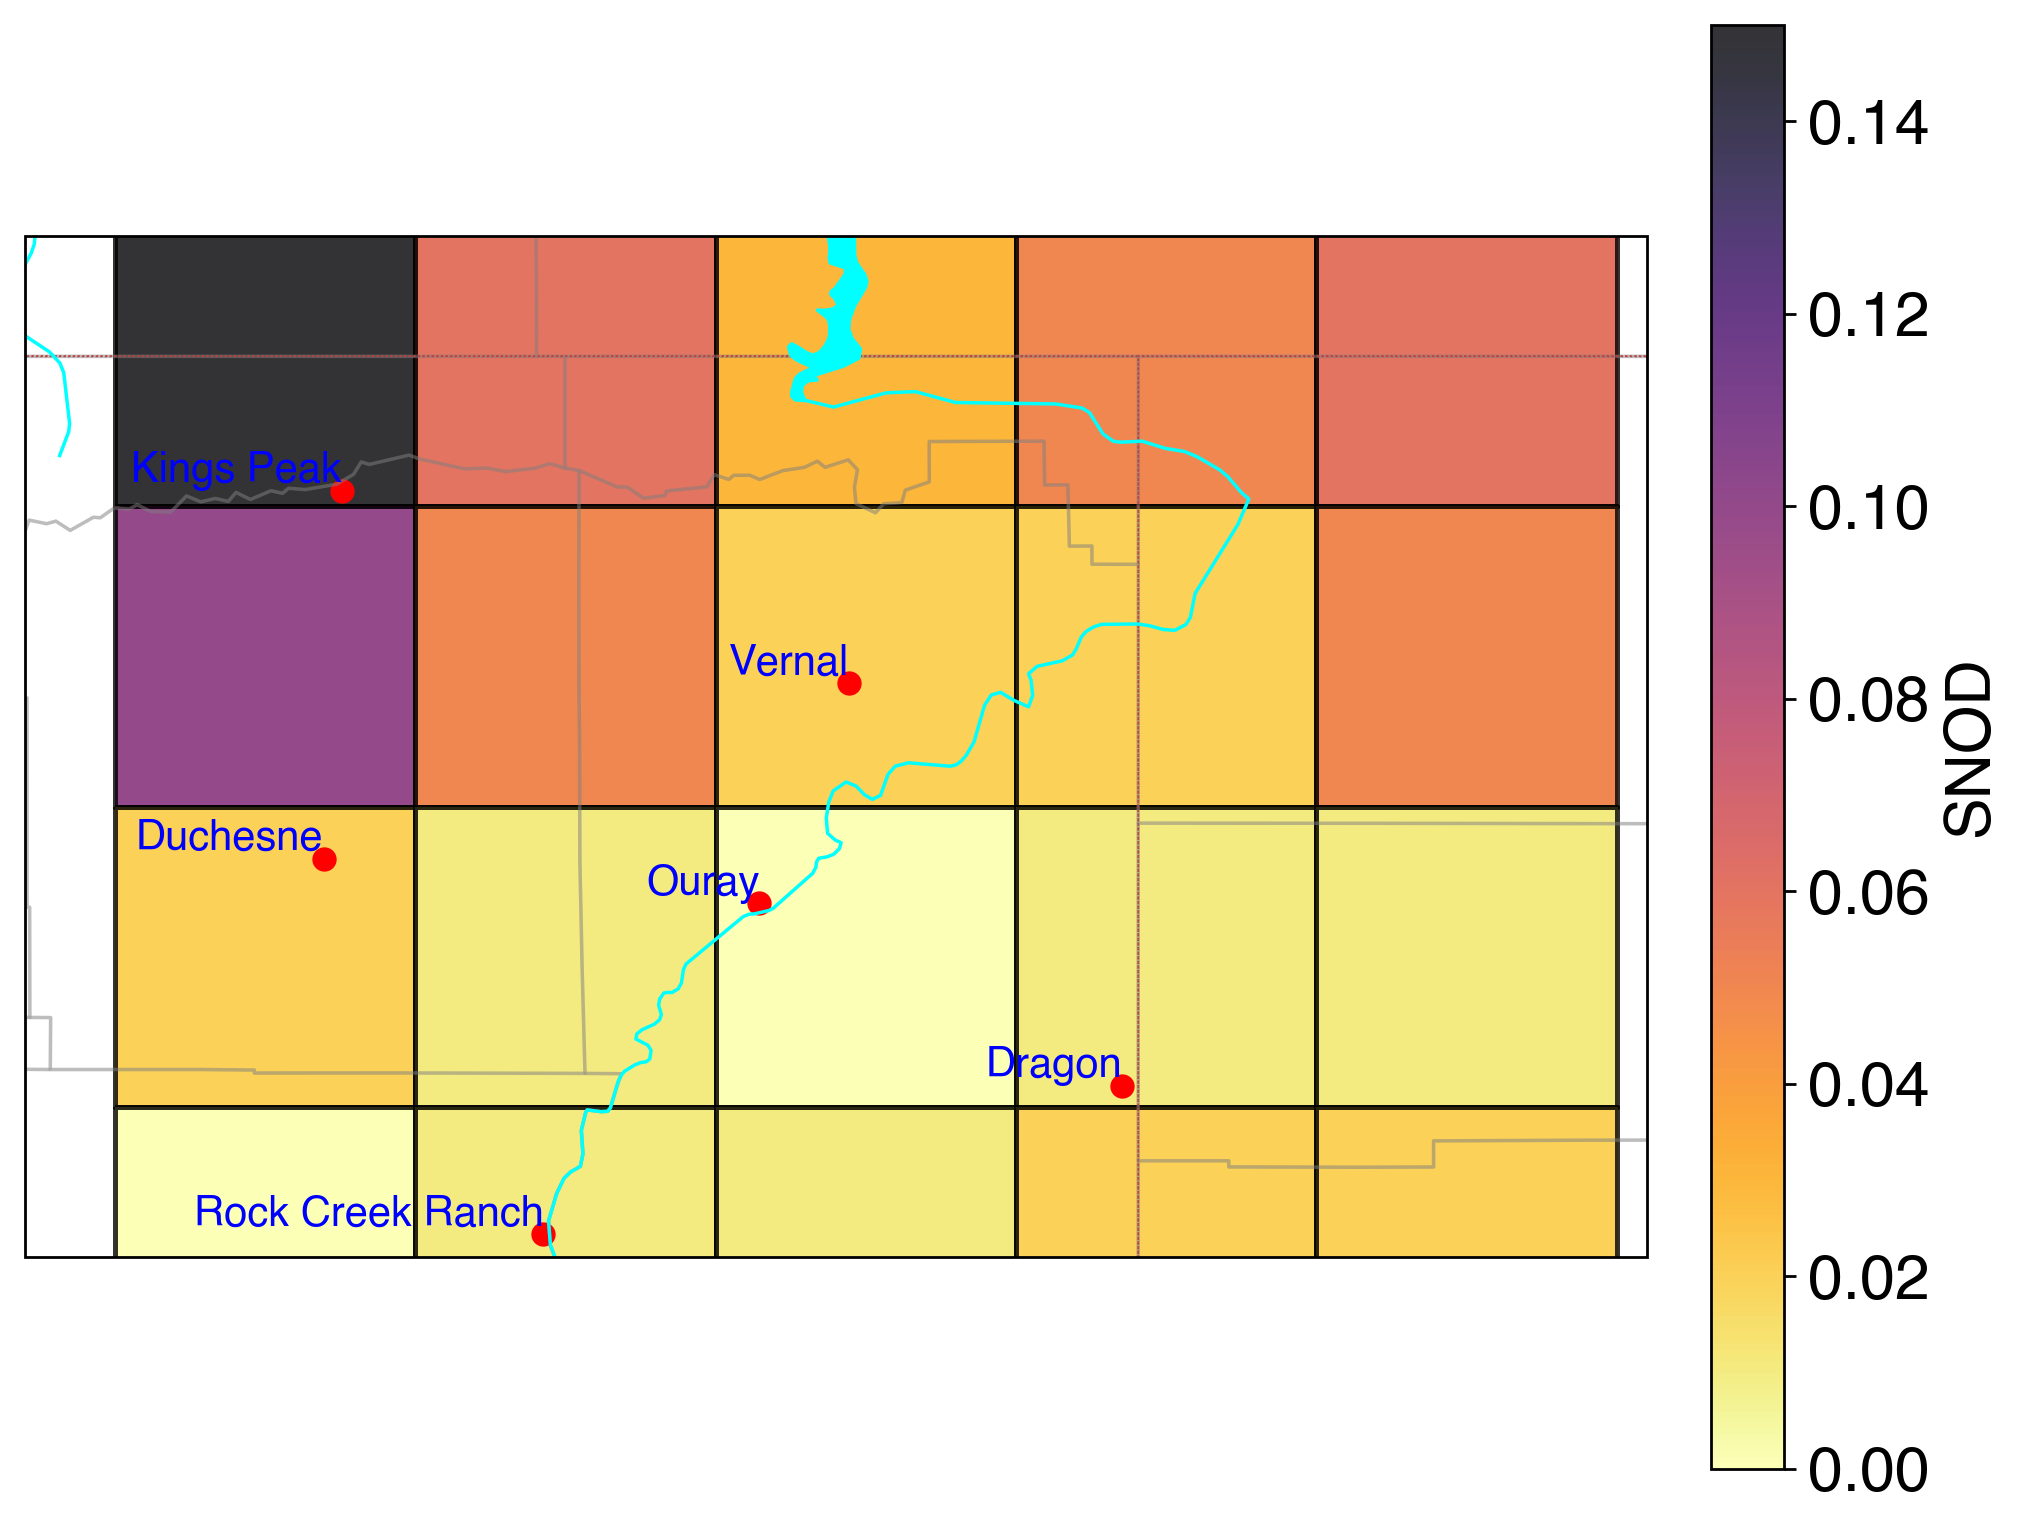

In [4]:
ds_snow = GEFSData.get_cropped_data(init_dt, fxx=6, q_str=":SNOD:", product="atmos.5", remove_grib=False)
fig, ax = plotting.surface_plot(ds_snow, "sde", fchr=0, label="SNOD", save=None,
                                    # vlim=(1, None), levels=clvs, plot_type="contourf",
                                    my_extent=[-110.9, -108.2, 41.2, 39.5]
                                    )
fig.show()


In [5]:
ds_snow

<xarray.Dataset> Size: 208B
Dimensions:              (latitude: 4, longitude: 5)
Coordinates:
    number               int64 8B 0
    time                 datetime64[ns] 8B 2023-12-05T06:00:00
    step                 timedelta64[ns] 8B 06:00:00
    surface              float64 8B 0.0
  * latitude             (latitude) float64 32B 41.0 40.5 40.0 39.5
  * longitude            (longitude) float64 40B -110.5 -110.0 ... -109.0 -108.5
    valid_time           datetime64[ns] 8B ...
    gribfile_projection  object 8B None
    metpy_crs            object 8B Projection: latitude_longitude
Data variables:
    sde                  (latitude, longitude) float32 80B 0.15 0.06 ... 0.02
Attributes:
    GRIB_edition:            2
    GRIB_centre:             kwbc
    GRIB_centreDescription:  US National Weather Service - NCEP
    GRIB_subCentre:          2
    Conventions:             CF-1.7
    institution:             US National Weather Service - NCEP
    model:                   gefs
    product:                 atmos.5
    description:             Global Ensemble Forecast System (GEFS)
    remote_grib:             https://noaa-gefs-pds.s3.amazonaws.com/gefs.2023...
    local_grib:              /Users/johnlawson/data/gefs/20231205/subset_e0b2...
    search:                  :SNOD:

In [6]:
# Compare forecast snow depth per grid cell to representative observation
# Number the grid cells so we can refer to them?
# This is (4,5) in the 0.5 degree grid
shp = ds_snow.sde.shape
shp

(4, 5)

In [7]:
grid_nums = np.arange(shp[0] * shp[1])
grid_nums_df = grid_nums.reshape(shp)
grid_nums_df

array([[ 0,  1,  2,  3,  4],
       [ 5,  6,  7,  8,  9],
       [10, 11, 12, 13, 14],
       [15, 16, 17, 18, 19]])

In [8]:
# For each local date, get GEFS 06Z UTC run (T=24h - T=0)
# Compare each grid point to representative obs

# Keys for GEFS 0p5:
# vrbls = ["SDE",]
# We need insolation, which is either explicit or derived from cloud cover, elevation, lat, lon.
# We need snow depth/accumulation - Michael's work on snow shadow and geographical snowfall distribution
# We need wind speed, maybe gust?. Maybe at higher level and bias-correct for surface
# We need MSLP for near KVEL



In [9]:
# For different ensemble members - percentiles etc